In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import chi2_contingency
from scipy.stats import f_oneway
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score,confusion_matrix,recall_score,f1_score,roc_curve,roc_auc_score,accuracy_score
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier

from sklearn.linear_model import Lasso

In [2]:
tl_df=pd.read_csv("Telco_Customer_Churn_Data.csv",na_values=" ")
tl_df.dtypes
tl_df.isnull().sum()
tl_df.shape

(7043, 21)

In [3]:
## non sence columns
non_sence=[]
for col in tl_df:
    if len(tl_df[col].value_counts())==1 or len(tl_df[col].value_counts())==tl_df.shape[0]:
        non_sence.append(col)
non_sence

['customerID']

In [4]:
tl_df.drop(columns=["customerID"],inplace=True)

In [5]:
tl_df["TotalCharges"]=tl_df["TotalCharges"].fillna(tl_df["TotalCharges"].mean())

In [6]:
### correlation checking for  cat to cat chi sqr
corr_chi=[]
for col in tl_df:
    if tl_df[col].dtype=="object":
        new=pd.crosstab(tl_df[col],tl_df["Churn"])
        result=chi2_contingency(new)
        if result[1]<0.05:
            corr_chi.append(col)
corr_chi        


['Partner',
 'Dependents',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [7]:
### correlation check for cont to cat
anova_corr=[]
for col in tl_df:
    if tl_df[col].dtype=="int64" or tl_df[col].dtype=="float64":
        new=list(tl_df["Churn"].value_counts().index)
        result=f_oneway(*(tl_df[tl_df["Churn"]==calls][col] for calls in new))
        if result[1]<0.05:
            anova_corr.append(col)
            
corr_df=corr_chi+anova_corr

In [8]:
corr_df=tl_df[corr_df]

In [9]:
corr_df.shape

(7043, 18)

In [10]:
y=corr_df["Churn"]
corr_df.drop(columns=["Churn"],inplace=True)

In [11]:
x_train,x_test,y_train,y_test=train_test_split(corr_df,y,test_size=0.20,random_state=43)
len(x_train),len(x_test),len(y_train),len(y_test)

(5634, 1409, 5634, 1409)

In [12]:
## scaling
scaler=StandardScaler()
cont=[i for i in x_train if x_train[i].dtype=="int64" or x_train[i].dtype=="float64"]
for col in cont:
    x_train[col]=scaler.fit_transform(np.array(x_train[col]).reshape(-1,1))
    x_test[col]=scaler.transform(np.array(x_test[col]).reshape(-1,1))

In [13]:
## encoding for cats
cat=[col for col in x_train if x_train[col].dtype=="object"]
oe_train=pd.get_dummies(x_train[cat])
oe_test=pd.get_dummies(x_test[cat])

In [14]:
train_oe,test_oe=oe_train.align(oe_test,join="inner",axis=1)

In [15]:
final_train=pd.concat([x_train[cont],train_oe],axis=1)
final_test=pd.concat([x_test[cont],test_oe],axis=1)

In [16]:
## fitting model
logreg=LogisticRegression()
logreg.fit(final_train,y_train)
test_pred=logreg.predict(final_test)
test_pred

array(['No', 'No', 'No', ..., 'No', 'Yes', 'No'], dtype=object)

In [17]:
## confusion matrix
confusion_matrix(test_pred,y_test)

array([[931, 160],
       [108, 210]], dtype=int64)

In [18]:
## test accuracy
accuracy_score(test_pred,y_test)

0.8097941802696949

In [19]:
## train accuracy
train_pred=logreg.predict(final_train)
accuracy_score(train_pred,y_train)

0.8061767838125665

In [20]:
recall_score(test_pred,y_test,pos_label="Yes")

0.660377358490566

In [21]:
precision_score(test_pred,y_test,pos_label="Yes")

0.5675675675675675

In [22]:
f1_score(test_pred,y_test,pos_label="Yes")

0.6104651162790697

In [23]:
pos_probs=logreg.predict_proba(final_test)[::,1]
pos_probs


array([0.31629872, 0.35808491, 0.14558155, ..., 0.12445471, 0.5560643 ,
       0.01624271])

In [24]:
fpr,tpr,threshold=roc_curve(y_test,pos_probs,pos_label="Yes")

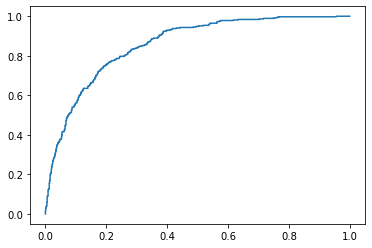

In [25]:
plt.plot(fpr,tpr)

In [26]:
roc_auc_score(y_test,pos_probs)

0.8579975548214239

# applying sgd classifier model to overcome over fitting

In [27]:
las=Lasso()
sgd=SGDClassifier(penalty="l2",verbose=0.001)
sgd.fit(final_train,y_train)
sgd_test_pred=sgd.predict(final_test)
coeffs=sgd.coef_
len(coeffs[coeffs==0])

0

In [28]:
## test accuracy
accuracy_score(y_test,sgd_test_pred)

0.8019872249822569

In [29]:
## train accuracy
sgd_train_pred=sgd.predict(final_train)
accuracy_score(sgd_train_pred,y_train)

0.7900248491302805

In [30]:
## recall score
recall_score(sgd_train_pred,y_train,pos_label="Yes")

0.6007653061224489

In [31]:
###precision_score
precision_score(sgd_train_pred,y_train,pos_label="Yes")

0.628418945963976

In [32]:
## f1 score
f1_score(sgd_train_pred,y_train,pos_label="Yes")

0.6142810564069122

# DECISSION TREE CLASSIFIER

In [33]:
from sklearn.tree import DecisionTreeClassifier
dtc=DecisionTreeClassifier()
dtc.fit(final_train,y_train)
test_pred=dtc.predict(final_test)
## test accuracy
accuracy_score (test_pred,y_test)

0.7352732434350603

In [34]:
confusion_matrix(test_pred,y_test)

array([[832, 166],
       [207, 204]], dtype=int64)

In [35]:
recall_score(test_pred,y_test,pos_label="Yes")

0.49635036496350365

In [36]:
precision_score(test_pred,y_test,pos_label="Yes")

0.5513513513513514

In [37]:
f1_score(test_pred,y_test,pos_label="Yes")

0.5224071702944943

# ADABOOST ALGORITHM

In [38]:
from sklearn.ensemble import AdaBoostClassifier

In [39]:
adb=AdaBoostClassifier()
adb.fit(final_train,y_train)
adb_test_pred=adb.predict(final_test)

In [40]:
# test accuracy
accuracy_score(adb_test_pred,y_test)

0.8105039034776437

In [41]:
## train accuracy
accuracy_score(y_train,adb.predict(final_train))

0.8061767838125665

In [42]:
recall_score(adb_test_pred,y_test,pos_label="Yes")

0.6655948553054662

In [43]:
precision_score(adb_test_pred,y_test,pos_label="Yes")

0.5594594594594594

# gradient boost algorithm

In [44]:
from sklearn.ensemble import GradientBoostingClassifier

In [45]:
gbr=GradientBoostingClassifier()
gbr.fit(final_train,y_train)
accuracy_score(y_test,gbr.predict(final_test))

0.8197303051809794

In [46]:
recall_score(y_test,gbr.predict(final_test),pos_label="Yes")

0.5594594594594594

In [47]:
precision_score(y_test,gbr.predict(final_test),pos_label="Yes")

0.6946308724832215

# SUPPORT VECTOR MACHINE


In [48]:
from sklearn.svm import SVC

In [49]:
svc=SVC()
svc.fit(final_train,y_train)

SVC()

In [50]:
accuracy_score(y_test,svc.predict(final_test))

0.8090844570617459

In [51]:
recall_score(y_test,svc.predict(final_test),pos_label="Yes")

0.518918918918919

In [52]:
precision_score(y_test,svc.predict(final_test),pos_label="Yes")

0.6784452296819788

In [53]:
# HYPER PARAMETER TUNING
# Grid search cv

In [54]:
from sklearn.model_selection import GridSearchCV

In [55]:
parameters={"max_depth":[20,40,60,80,100],
           "min_samples_split":[2,4,6,8,10],
           "min_samples_leaf":[1,2,3,4,5],
           "max_leaf_nodes":[1,3,5,7]}

In [56]:
grd=GridSearchCV(gbr,param_grid=parameters,cv=6,verbose=20)

In [57]:
grd.fit(final_train,y_train)

Fitting 6 folds for each of 500 candidates, totalling 3000 fits
[CV 1/6; 1/500] START max_depth=20, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=2
[CV 1/6; 1/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=2;, score=nan total time=   0.0s
[CV 2/6; 1/500] START max_depth=20, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=2
[CV 2/6; 1/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=2;, score=nan total time=   0.0s
[CV 3/6; 1/500] START max_depth=20, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=2
[CV 3/6; 1/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=2;, score=nan total time=   0.0s
[CV 4/6; 1/500] START max_depth=20, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=2
[CV 4/6; 1/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=2;, score=nan total time=   0.0s
[CV 5/6; 1/500] START max_depth=20, max_leaf_nodes=1, min_samples_le

[CV 3/6; 7/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=4;, score=nan total time=   0.0s
[CV 4/6; 7/500] START max_depth=20, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=4
[CV 4/6; 7/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=4;, score=nan total time=   0.0s
[CV 5/6; 7/500] START max_depth=20, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=4
[CV 5/6; 7/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=4;, score=nan total time=   0.0s
[CV 6/6; 7/500] START max_depth=20, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=4
[CV 6/6; 7/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=4;, score=nan total time=   0.0s
[CV 1/6; 8/500] START max_depth=20, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=6
[CV 1/6; 8/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=6;, score=nan total time=   0.0s
[CV 2/6; 

[CV 4/6; 14/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=8;, score=nan total time=   0.0s
[CV 5/6; 14/500] START max_depth=20, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=8
[CV 5/6; 14/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=8;, score=nan total time=   0.0s
[CV 6/6; 14/500] START max_depth=20, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=8
[CV 6/6; 14/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=8;, score=nan total time=   0.0s
[CV 1/6; 15/500] START max_depth=20, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=10
[CV 1/6; 15/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=10;, score=nan total time=   0.0s
[CV 2/6; 15/500] START max_depth=20, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=10
[CV 2/6; 15/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=10;, score=nan total time=   0

[CV 5/6; 21/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=2;, score=nan total time=   0.0s
[CV 6/6; 21/500] START max_depth=20, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=2
[CV 6/6; 21/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=2;, score=nan total time=   0.0s
[CV 1/6; 22/500] START max_depth=20, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=4
[CV 1/6; 22/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=4;, score=nan total time=   0.0s
[CV 2/6; 22/500] START max_depth=20, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=4
[CV 2/6; 22/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=4;, score=nan total time=   0.0s
[CV 3/6; 22/500] START max_depth=20, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=4
[CV 3/6; 22/500] END max_depth=20, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=4;, score=nan total time=   0.0s


[CV 1/6; 28/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=6;, score=0.802 total time=   0.7s
[CV 2/6; 28/500] START max_depth=20, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=6
[CV 2/6; 28/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=6;, score=0.809 total time=   0.6s
[CV 3/6; 28/500] START max_depth=20, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=6
[CV 3/6; 28/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=6;, score=0.804 total time=   0.6s
[CV 4/6; 28/500] START max_depth=20, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=6
[CV 4/6; 28/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=6;, score=0.785 total time=   0.6s
[CV 5/6; 28/500] START max_depth=20, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=6
[CV 5/6; 28/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=6;, score=0.802 total tim

[CV 3/6; 34/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=8;, score=0.804 total time=   0.6s
[CV 4/6; 34/500] START max_depth=20, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=8
[CV 4/6; 34/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=8;, score=0.783 total time=   0.6s
[CV 5/6; 34/500] START max_depth=20, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=8
[CV 5/6; 34/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=8;, score=0.801 total time=   0.5s
[CV 6/6; 34/500] START max_depth=20, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=8
[CV 6/6; 34/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=8;, score=0.813 total time=   0.6s
[CV 1/6; 35/500] START max_depth=20, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=10
[CV 1/6; 35/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=10;, score=0.802 total t

[CV 4/6; 40/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=10;, score=0.780 total time=   0.5s
[CV 5/6; 40/500] START max_depth=20, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=10
[CV 5/6; 40/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=10;, score=0.801 total time=   0.6s
[CV 6/6; 40/500] START max_depth=20, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=10
[CV 6/6; 40/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=10;, score=0.816 total time=   0.6s
[CV 1/6; 41/500] START max_depth=20, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=2
[CV 1/6; 41/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=2;, score=0.802 total time=   0.6s
[CV 2/6; 41/500] START max_depth=20, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=2
[CV 2/6; 41/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=2;, score=0.809 tota

[CV 5/6; 46/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=2;, score=0.801 total time=   0.7s
[CV 6/6; 46/500] START max_depth=20, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=2
[CV 6/6; 46/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=2;, score=0.815 total time=   0.6s
[CV 1/6; 47/500] START max_depth=20, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=4
[CV 1/6; 47/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=4;, score=0.802 total time=   0.5s
[CV 2/6; 47/500] START max_depth=20, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=4
[CV 2/6; 47/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=4;, score=0.806 total time=   0.6s
[CV 3/6; 47/500] START max_depth=20, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=4
[CV 3/6; 47/500] END max_depth=20, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=4;, score=0.799 total tim

[CV 1/6; 53/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=6;, score=0.797 total time=   0.9s
[CV 2/6; 53/500] START max_depth=20, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=6
[CV 2/6; 53/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=6;, score=0.804 total time=   0.8s
[CV 3/6; 53/500] START max_depth=20, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=6
[CV 3/6; 53/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=6;, score=0.797 total time=   0.8s
[CV 4/6; 53/500] START max_depth=20, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=6
[CV 4/6; 53/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=6;, score=0.788 total time=   0.9s
[CV 5/6; 53/500] START max_depth=20, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=6
[CV 5/6; 53/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=6;, score=0.797 total tim

[CV 3/6; 59/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=8;, score=0.799 total time=   0.9s
[CV 4/6; 59/500] START max_depth=20, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=8
[CV 4/6; 59/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=8;, score=0.786 total time=   0.9s
[CV 5/6; 59/500] START max_depth=20, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=8
[CV 5/6; 59/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=8;, score=0.799 total time=   0.9s
[CV 6/6; 59/500] START max_depth=20, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=8
[CV 6/6; 59/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=8;, score=0.807 total time=   1.0s
[CV 1/6; 60/500] START max_depth=20, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=10
[CV 1/6; 60/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=10;, score=0.796 total t

[CV 4/6; 65/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=10;, score=0.791 total time=   0.8s
[CV 5/6; 65/500] START max_depth=20, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=10
[CV 5/6; 65/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=10;, score=0.803 total time=   0.8s
[CV 6/6; 65/500] START max_depth=20, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=10
[CV 6/6; 65/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=10;, score=0.806 total time=   0.8s
[CV 1/6; 66/500] START max_depth=20, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=2
[CV 1/6; 66/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=2;, score=0.802 total time=   0.8s
[CV 2/6; 66/500] START max_depth=20, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=2
[CV 2/6; 66/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=2;, score=0.802 tota

[CV 5/6; 71/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=2;, score=0.800 total time=   0.8s
[CV 6/6; 71/500] START max_depth=20, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=2
[CV 6/6; 71/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=2;, score=0.807 total time=   0.7s
[CV 1/6; 72/500] START max_depth=20, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=4
[CV 1/6; 72/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=4;, score=0.801 total time=   0.7s
[CV 2/6; 72/500] START max_depth=20, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=4
[CV 2/6; 72/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=4;, score=0.804 total time=   0.9s
[CV 3/6; 72/500] START max_depth=20, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=4
[CV 3/6; 72/500] END max_depth=20, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=4;, score=0.799 total tim

[CV 1/6; 78/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=6;, score=0.789 total time=   0.8s
[CV 2/6; 78/500] START max_depth=20, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=6
[CV 2/6; 78/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=6;, score=0.803 total time=   0.8s
[CV 3/6; 78/500] START max_depth=20, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=6
[CV 3/6; 78/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=6;, score=0.790 total time=   0.8s
[CV 4/6; 78/500] START max_depth=20, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=6
[CV 4/6; 78/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=6;, score=0.777 total time=   0.8s
[CV 5/6; 78/500] START max_depth=20, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=6
[CV 5/6; 78/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=6;, score=0.807 total tim

[CV 3/6; 84/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=8;, score=0.792 total time=   0.8s
[CV 4/6; 84/500] START max_depth=20, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=8
[CV 4/6; 84/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=8;, score=0.781 total time=   0.8s
[CV 5/6; 84/500] START max_depth=20, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=8
[CV 5/6; 84/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=8;, score=0.800 total time=   0.9s
[CV 6/6; 84/500] START max_depth=20, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=8
[CV 6/6; 84/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=8;, score=0.802 total time=   0.9s
[CV 1/6; 85/500] START max_depth=20, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=10
[CV 1/6; 85/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=10;, score=0.792 total t

[CV 4/6; 90/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=10;, score=0.781 total time=   1.1s
[CV 5/6; 90/500] START max_depth=20, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=10
[CV 5/6; 90/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=10;, score=0.806 total time=   1.1s
[CV 6/6; 90/500] START max_depth=20, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=10
[CV 6/6; 90/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=10;, score=0.796 total time=   1.1s
[CV 1/6; 91/500] START max_depth=20, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=2
[CV 1/6; 91/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=2;, score=0.796 total time=   1.1s
[CV 2/6; 91/500] START max_depth=20, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=2
[CV 2/6; 91/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=2;, score=0.801 tota

[CV 5/6; 96/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=2;, score=0.805 total time=   1.0s
[CV 6/6; 96/500] START max_depth=20, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=2
[CV 6/6; 96/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=2;, score=0.792 total time=   1.0s
[CV 1/6; 97/500] START max_depth=20, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4
[CV 1/6; 97/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4;, score=0.791 total time=   1.0s
[CV 2/6; 97/500] START max_depth=20, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4
[CV 2/6; 97/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4;, score=0.805 total time=   0.8s
[CV 3/6; 97/500] START max_depth=20, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4
[CV 3/6; 97/500] END max_depth=20, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4;, score=0.794 total tim

[CV 2/6; 103/500] END max_depth=40, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=6;, score=nan total time=   0.0s
[CV 3/6; 103/500] START max_depth=40, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=6
[CV 3/6; 103/500] END max_depth=40, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=6;, score=nan total time=   0.0s
[CV 4/6; 103/500] START max_depth=40, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=6
[CV 4/6; 103/500] END max_depth=40, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=6;, score=nan total time=   0.0s
[CV 5/6; 103/500] START max_depth=40, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=6
[CV 5/6; 103/500] END max_depth=40, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=6;, score=nan total time=   0.0s
[CV 6/6; 103/500] START max_depth=40, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=6
[CV 6/6; 103/500] END max_depth=40, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=6;, score=nan total time

[CV 5/6; 111/500] END max_depth=40, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=2;, score=nan total time=   0.0s
[CV 6/6; 111/500] START max_depth=40, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=2
[CV 6/6; 111/500] END max_depth=40, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=2;, score=nan total time=   0.0s
[CV 1/6; 112/500] START max_depth=40, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=4
[CV 1/6; 112/500] END max_depth=40, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=4;, score=nan total time=   0.0s
[CV 2/6; 112/500] START max_depth=40, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=4
[CV 2/6; 112/500] END max_depth=40, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=4;, score=nan total time=   0.0s
[CV 3/6; 112/500] START max_depth=40, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=4
[CV 3/6; 112/500] END max_depth=40, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=4;, score=nan total time

[CV 4/6; 120/500] END max_depth=40, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=10;, score=nan total time=   0.0s
[CV 5/6; 120/500] START max_depth=40, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=10
[CV 5/6; 120/500] END max_depth=40, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=10;, score=nan total time=   0.0s
[CV 6/6; 120/500] START max_depth=40, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=10
[CV 6/6; 120/500] END max_depth=40, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=10;, score=nan total time=   0.0s
[CV 1/6; 121/500] START max_depth=40, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=2
[CV 1/6; 121/500] END max_depth=40, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=2;, score=nan total time=   0.0s
[CV 2/6; 121/500] START max_depth=40, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=2
[CV 2/6; 121/500] END max_depth=40, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=2;, score=nan total

[CV 5/6; 126/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2;, score=0.802 total time=   0.8s
[CV 6/6; 126/500] START max_depth=40, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2
[CV 6/6; 126/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2;, score=0.814 total time=   0.7s
[CV 1/6; 127/500] START max_depth=40, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=4
[CV 1/6; 127/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=4;, score=0.802 total time=   0.7s
[CV 2/6; 127/500] START max_depth=40, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=4
[CV 2/6; 127/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=4;, score=0.809 total time=   0.7s
[CV 3/6; 127/500] START max_depth=40, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=4
[CV 3/6; 127/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=4;, score=0.804 

[CV 6/6; 132/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=4;, score=0.813 total time=   0.7s
[CV 1/6; 133/500] START max_depth=40, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=6
[CV 1/6; 133/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=6;, score=0.802 total time=   0.7s
[CV 2/6; 133/500] START max_depth=40, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=6
[CV 2/6; 133/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=6;, score=0.808 total time=   0.7s
[CV 3/6; 133/500] START max_depth=40, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=6
[CV 3/6; 133/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=6;, score=0.804 total time=   0.7s
[CV 4/6; 133/500] START max_depth=40, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=6
[CV 4/6; 133/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=6;, score=0.783 

[CV 1/6; 139/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8;, score=0.802 total time=   0.8s
[CV 2/6; 139/500] START max_depth=40, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8
[CV 2/6; 139/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8;, score=0.808 total time=   0.7s
[CV 3/6; 139/500] START max_depth=40, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8
[CV 3/6; 139/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8;, score=0.804 total time=   0.7s
[CV 4/6; 139/500] START max_depth=40, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8
[CV 4/6; 139/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8;, score=0.780 total time=   0.7s
[CV 5/6; 139/500] START max_depth=40, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8
[CV 5/6; 139/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8;, score=0.801 

[CV 2/6; 145/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=10;, score=0.809 total time=   0.7s
[CV 3/6; 145/500] START max_depth=40, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=10
[CV 3/6; 145/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=10;, score=0.804 total time=   0.7s
[CV 4/6; 145/500] START max_depth=40, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=10
[CV 4/6; 145/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=10;, score=0.780 total time=   0.7s
[CV 5/6; 145/500] START max_depth=40, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=10
[CV 5/6; 145/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=10;, score=0.799 total time=   0.8s
[CV 6/6; 145/500] START max_depth=40, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=10
[CV 6/6; 145/500] END max_depth=40, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=10;, sco

[CV 3/6; 151/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2;, score=0.796 total time=   0.9s
[CV 4/6; 151/500] START max_depth=40, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2
[CV 4/6; 151/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2;, score=0.787 total time=   1.0s
[CV 5/6; 151/500] START max_depth=40, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2
[CV 5/6; 151/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2;, score=0.799 total time=   1.0s
[CV 6/6; 151/500] START max_depth=40, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2
[CV 6/6; 151/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2;, score=0.810 total time=   1.0s
[CV 1/6; 152/500] START max_depth=40, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=4
[CV 1/6; 152/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=4;, score=0.797 

[CV 4/6; 157/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4;, score=0.786 total time=   0.9s
[CV 5/6; 157/500] START max_depth=40, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4
[CV 5/6; 157/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4;, score=0.799 total time=   0.9s
[CV 6/6; 157/500] START max_depth=40, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4
[CV 6/6; 157/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4;, score=0.808 total time=   1.0s
[CV 1/6; 158/500] START max_depth=40, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=6
[CV 1/6; 158/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=6;, score=0.798 total time=   0.9s
[CV 2/6; 158/500] START max_depth=40, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=6
[CV 2/6; 158/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=6;, score=0.805 

[CV 5/6; 163/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=6;, score=0.801 total time=   0.9s
[CV 6/6; 163/500] START max_depth=40, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=6
[CV 6/6; 163/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=6;, score=0.808 total time=   0.8s
[CV 1/6; 164/500] START max_depth=40, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=8
[CV 1/6; 164/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=8;, score=0.796 total time=   0.9s
[CV 2/6; 164/500] START max_depth=40, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=8
[CV 2/6; 164/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=8;, score=0.805 total time=   0.9s
[CV 3/6; 164/500] START max_depth=40, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=8
[CV 3/6; 164/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=8;, score=0.801 

[CV 6/6; 169/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8;, score=0.808 total time=   0.9s
[CV 1/6; 170/500] START max_depth=40, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=10
[CV 1/6; 170/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=10;, score=0.800 total time=   0.8s
[CV 2/6; 170/500] START max_depth=40, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=10
[CV 2/6; 170/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=10;, score=0.804 total time=   0.9s
[CV 3/6; 170/500] START max_depth=40, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=10
[CV 3/6; 170/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=10;, score=0.800 total time=   1.0s
[CV 4/6; 170/500] START max_depth=40, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=10
[CV 4/6; 170/500] END max_depth=40, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=10;, scor

[CV 1/6; 176/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=2;, score=0.790 total time=   0.9s
[CV 2/6; 176/500] START max_depth=40, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=2
[CV 2/6; 176/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=2;, score=0.804 total time=   1.1s
[CV 3/6; 176/500] START max_depth=40, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=2
[CV 3/6; 176/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=2;, score=0.797 total time=   1.0s
[CV 4/6; 176/500] START max_depth=40, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=2
[CV 4/6; 176/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=2;, score=0.780 total time=   1.1s
[CV 5/6; 176/500] START max_depth=40, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=2
[CV 5/6; 176/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=2;, score=0.812 

[CV 2/6; 182/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4;, score=0.803 total time=   1.0s
[CV 3/6; 182/500] START max_depth=40, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4
[CV 3/6; 182/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4;, score=0.798 total time=   1.0s
[CV 4/6; 182/500] START max_depth=40, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4
[CV 4/6; 182/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4;, score=0.780 total time=   1.0s
[CV 5/6; 182/500] START max_depth=40, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4
[CV 5/6; 182/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4;, score=0.807 total time=   1.0s
[CV 6/6; 182/500] START max_depth=40, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4
[CV 6/6; 182/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4;, score=0.798 

[CV 3/6; 188/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6;, score=0.796 total time=   0.9s
[CV 4/6; 188/500] START max_depth=40, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6
[CV 4/6; 188/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6;, score=0.785 total time=   1.0s
[CV 5/6; 188/500] START max_depth=40, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6
[CV 5/6; 188/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6;, score=0.812 total time=   1.0s
[CV 6/6; 188/500] START max_depth=40, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6
[CV 6/6; 188/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6;, score=0.799 total time=   1.1s
[CV 1/6; 189/500] START max_depth=40, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=8
[CV 1/6; 189/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=8;, score=0.796 

[CV 4/6; 194/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8;, score=0.786 total time=   1.1s
[CV 5/6; 194/500] START max_depth=40, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8
[CV 5/6; 194/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8;, score=0.806 total time=   1.0s
[CV 6/6; 194/500] START max_depth=40, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8
[CV 6/6; 194/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8;, score=0.799 total time=   0.9s
[CV 1/6; 195/500] START max_depth=40, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=10
[CV 1/6; 195/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=10;, score=0.796 total time=   0.9s
[CV 2/6; 195/500] START max_depth=40, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=10
[CV 2/6; 195/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=10;, score=0.

[CV 5/6; 200/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=10;, score=0.805 total time=   1.0s
[CV 6/6; 200/500] START max_depth=40, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=10
[CV 6/6; 200/500] END max_depth=40, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=10;, score=0.792 total time=   1.1s
[CV 1/6; 201/500] START max_depth=60, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=2
[CV 1/6; 201/500] END max_depth=60, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=2;, score=nan total time=   0.0s
[CV 2/6; 201/500] START max_depth=60, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=2
[CV 2/6; 201/500] END max_depth=60, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=2;, score=nan total time=   0.0s
[CV 3/6; 201/500] START max_depth=60, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=2
[CV 3/6; 201/500] END max_depth=60, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=2;, score=nan tot

[CV 5/6; 208/500] END max_depth=60, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=6;, score=nan total time=   0.0s
[CV 6/6; 208/500] START max_depth=60, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=6
[CV 6/6; 208/500] END max_depth=60, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=6;, score=nan total time=   0.0s
[CV 1/6; 209/500] START max_depth=60, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=8
[CV 1/6; 209/500] END max_depth=60, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=8;, score=nan total time=   0.0s
[CV 2/6; 209/500] START max_depth=60, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=8
[CV 2/6; 209/500] END max_depth=60, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=8;, score=nan total time=   0.0s
[CV 3/6; 209/500] START max_depth=60, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=8
[CV 3/6; 209/500] END max_depth=60, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=8;, score=nan total time

[CV 6/6; 215/500] END max_depth=60, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=10;, score=nan total time=   0.0s
[CV 1/6; 216/500] START max_depth=60, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=2
[CV 1/6; 216/500] END max_depth=60, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=2;, score=nan total time=   0.0s
[CV 2/6; 216/500] START max_depth=60, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=2
[CV 2/6; 216/500] END max_depth=60, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=2;, score=nan total time=   0.0s
[CV 3/6; 216/500] START max_depth=60, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=2
[CV 3/6; 216/500] END max_depth=60, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=2;, score=nan total time=   0.0s
[CV 4/6; 216/500] START max_depth=60, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=2
[CV 4/6; 216/500] END max_depth=60, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=2;, score=nan total tim

[CV 6/6; 223/500] END max_depth=60, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=6;, score=nan total time=   0.0s
[CV 1/6; 224/500] START max_depth=60, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=8
[CV 1/6; 224/500] END max_depth=60, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=8;, score=nan total time=   0.0s
[CV 2/6; 224/500] START max_depth=60, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=8
[CV 2/6; 224/500] END max_depth=60, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=8;, score=nan total time=   0.0s
[CV 3/6; 224/500] START max_depth=60, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=8
[CV 3/6; 224/500] END max_depth=60, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=8;, score=nan total time=   0.0s
[CV 4/6; 224/500] START max_depth=60, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=8
[CV 4/6; 224/500] END max_depth=60, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=8;, score=nan total time

[CV 1/6; 230/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10;, score=0.802 total time=   0.9s
[CV 2/6; 230/500] START max_depth=60, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10
[CV 2/6; 230/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10;, score=0.809 total time=   0.7s
[CV 3/6; 230/500] START max_depth=60, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10
[CV 3/6; 230/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10;, score=0.804 total time=   0.7s
[CV 4/6; 230/500] START max_depth=60, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10
[CV 4/6; 230/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10;, score=0.785 total time=   0.7s
[CV 5/6; 230/500] START max_depth=60, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10
[CV 5/6; 230/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10;, sco

[CV 2/6; 236/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=2;, score=0.808 total time=   0.7s
[CV 3/6; 236/500] START max_depth=60, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=2
[CV 3/6; 236/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=2;, score=0.804 total time=   0.6s
[CV 4/6; 236/500] START max_depth=60, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=2
[CV 4/6; 236/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=2;, score=0.780 total time=   0.6s
[CV 5/6; 236/500] START max_depth=60, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=2
[CV 5/6; 236/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=2;, score=0.801 total time=   0.6s
[CV 6/6; 236/500] START max_depth=60, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=2
[CV 6/6; 236/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=2;, score=0.816 

[CV 3/6; 242/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=4;, score=0.803 total time=   0.7s
[CV 4/6; 242/500] START max_depth=60, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=4
[CV 4/6; 242/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=4;, score=0.780 total time=   0.8s
[CV 5/6; 242/500] START max_depth=60, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=4
[CV 5/6; 242/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=4;, score=0.799 total time=   0.7s
[CV 6/6; 242/500] START max_depth=60, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=4
[CV 6/6; 242/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=4;, score=0.815 total time=   0.7s
[CV 1/6; 243/500] START max_depth=60, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=6
[CV 1/6; 243/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=6;, score=0.802 

[CV 4/6; 248/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6;, score=0.784 total time=   0.7s
[CV 5/6; 248/500] START max_depth=60, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6
[CV 5/6; 248/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6;, score=0.801 total time=   0.8s
[CV 6/6; 248/500] START max_depth=60, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6
[CV 6/6; 248/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6;, score=0.815 total time=   0.7s
[CV 1/6; 249/500] START max_depth=60, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=8
[CV 1/6; 249/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=8;, score=0.802 total time=   0.7s
[CV 2/6; 249/500] START max_depth=60, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=8
[CV 2/6; 249/500] END max_depth=60, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=8;, score=0.806 

[CV 5/6; 254/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=8;, score=0.797 total time=   0.9s
[CV 6/6; 254/500] START max_depth=60, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=8
[CV 6/6; 254/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=8;, score=0.810 total time=   0.9s
[CV 1/6; 255/500] START max_depth=60, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=10
[CV 1/6; 255/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=10;, score=0.796 total time=   0.8s
[CV 2/6; 255/500] START max_depth=60, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=10
[CV 2/6; 255/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=10;, score=0.804 total time=   0.8s
[CV 3/6; 255/500] START max_depth=60, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=10
[CV 3/6; 255/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=10;, score=

[CV 6/6; 260/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=10;, score=0.807 total time=   1.0s
[CV 1/6; 261/500] START max_depth=60, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=2
[CV 1/6; 261/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=2;, score=0.796 total time=   0.9s
[CV 2/6; 261/500] START max_depth=60, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=2
[CV 2/6; 261/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=2;, score=0.805 total time=   0.9s
[CV 3/6; 261/500] START max_depth=60, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=2
[CV 3/6; 261/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=2;, score=0.801 total time=   1.0s
[CV 4/6; 261/500] START max_depth=60, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=2
[CV 4/6; 261/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=2;, score=0.790

[CV 1/6; 267/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4;, score=0.802 total time=   0.9s
[CV 2/6; 267/500] START max_depth=60, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4
[CV 2/6; 267/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4;, score=0.802 total time=   0.8s
[CV 3/6; 267/500] START max_depth=60, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4
[CV 3/6; 267/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4;, score=0.800 total time=   0.9s
[CV 4/6; 267/500] START max_depth=60, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4
[CV 4/6; 267/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4;, score=0.789 total time=   0.9s
[CV 5/6; 267/500] START max_depth=60, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4
[CV 5/6; 267/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4;, score=0.799 

[CV 2/6; 273/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=6;, score=0.804 total time=   0.9s
[CV 3/6; 273/500] START max_depth=60, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=6
[CV 3/6; 273/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=6;, score=0.799 total time=   0.8s
[CV 4/6; 273/500] START max_depth=60, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=6
[CV 4/6; 273/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=6;, score=0.787 total time=   0.9s
[CV 5/6; 273/500] START max_depth=60, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=6
[CV 5/6; 273/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=6;, score=0.800 total time=   0.8s
[CV 6/6; 273/500] START max_depth=60, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=6
[CV 6/6; 273/500] END max_depth=60, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=6;, score=0.807 

[CV 3/6; 279/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=8;, score=0.787 total time=   1.0s
[CV 4/6; 279/500] START max_depth=60, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=8
[CV 4/6; 279/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=8;, score=0.785 total time=   1.1s
[CV 5/6; 279/500] START max_depth=60, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=8
[CV 5/6; 279/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=8;, score=0.807 total time=   1.0s
[CV 6/6; 279/500] START max_depth=60, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=8
[CV 6/6; 279/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=8;, score=0.798 total time=   1.0s
[CV 1/6; 280/500] START max_depth=60, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=10
[CV 1/6; 280/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=10;, score=0.78

[CV 4/6; 285/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=10;, score=0.783 total time=   1.1s
[CV 5/6; 285/500] START max_depth=60, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=10
[CV 5/6; 285/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=10;, score=0.810 total time=   1.0s
[CV 6/6; 285/500] START max_depth=60, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=10
[CV 6/6; 285/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=10;, score=0.799 total time=   1.1s
[CV 1/6; 286/500] START max_depth=60, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=2
[CV 1/6; 286/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=2;, score=0.793 total time=   1.0s
[CV 2/6; 286/500] START max_depth=60, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=2
[CV 2/6; 286/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=2;, score=0

[CV 5/6; 291/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=2;, score=0.807 total time=   1.0s
[CV 6/6; 291/500] START max_depth=60, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=2
[CV 6/6; 291/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=2;, score=0.799 total time=   0.9s
[CV 1/6; 292/500] START max_depth=60, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4
[CV 1/6; 292/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4;, score=0.796 total time=   0.9s
[CV 2/6; 292/500] START max_depth=60, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4
[CV 2/6; 292/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4;, score=0.801 total time=   1.0s
[CV 3/6; 292/500] START max_depth=60, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4
[CV 3/6; 292/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4;, score=0.798 

[CV 6/6; 297/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4;, score=0.792 total time=   1.1s
[CV 1/6; 298/500] START max_depth=60, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=6
[CV 1/6; 298/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=6;, score=0.791 total time=   1.1s
[CV 2/6; 298/500] START max_depth=60, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=6
[CV 2/6; 298/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=6;, score=0.805 total time=   1.1s
[CV 3/6; 298/500] START max_depth=60, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=6
[CV 3/6; 298/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=6;, score=0.794 total time=   0.9s
[CV 4/6; 298/500] START max_depth=60, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=6
[CV 4/6; 298/500] END max_depth=60, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=6;, score=0.783 

[CV 2/6; 304/500] END max_depth=80, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=8;, score=nan total time=   0.0s
[CV 3/6; 304/500] START max_depth=80, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=8
[CV 3/6; 304/500] END max_depth=80, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=8;, score=nan total time=   0.0s
[CV 4/6; 304/500] START max_depth=80, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=8
[CV 4/6; 304/500] END max_depth=80, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=8;, score=nan total time=   0.0s
[CV 5/6; 304/500] START max_depth=80, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=8
[CV 5/6; 304/500] END max_depth=80, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=8;, score=nan total time=   0.0s
[CV 6/6; 304/500] START max_depth=80, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=8
[CV 6/6; 304/500] END max_depth=80, max_leaf_nodes=1, min_samples_leaf=1, min_samples_split=8;, score=nan total time

[CV 4/6; 310/500] END max_depth=80, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=10;, score=nan total time=   0.0s
[CV 5/6; 310/500] START max_depth=80, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=10
[CV 5/6; 310/500] END max_depth=80, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=10;, score=nan total time=   0.0s
[CV 6/6; 310/500] START max_depth=80, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=10
[CV 6/6; 310/500] END max_depth=80, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=10;, score=nan total time=   0.0s
[CV 1/6; 311/500] START max_depth=80, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=2
[CV 1/6; 311/500] END max_depth=80, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=2;, score=nan total time=   0.0s
[CV 2/6; 311/500] START max_depth=80, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=2
[CV 2/6; 311/500] END max_depth=80, max_leaf_nodes=1, min_samples_leaf=3, min_samples_split=2;, score=nan total

[CV 3/6; 317/500] END max_depth=80, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=4;, score=nan total time=   0.0s
[CV 4/6; 317/500] START max_depth=80, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=4
[CV 4/6; 317/500] END max_depth=80, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=4;, score=nan total time=   0.0s
[CV 5/6; 317/500] START max_depth=80, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=4
[CV 5/6; 317/500] END max_depth=80, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=4;, score=nan total time=   0.0s
[CV 6/6; 317/500] START max_depth=80, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=4
[CV 6/6; 317/500] END max_depth=80, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=4;, score=nan total time=   0.0s
[CV 1/6; 318/500] START max_depth=80, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=6
[CV 1/6; 318/500] END max_depth=80, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=6;, score=nan total time

[CV 1/6; 326/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2;, score=0.802 total time=   0.8s
[CV 2/6; 326/500] START max_depth=80, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2
[CV 2/6; 326/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2;, score=0.809 total time=   0.7s
[CV 3/6; 326/500] START max_depth=80, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2
[CV 3/6; 326/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2;, score=0.804 total time=   0.6s
[CV 4/6; 326/500] START max_depth=80, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2
[CV 4/6; 326/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2;, score=0.785 total time=   0.6s
[CV 5/6; 326/500] START max_depth=80, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2
[CV 5/6; 326/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=2;, score=0.802 

[CV 2/6; 332/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=4;, score=0.809 total time=   0.7s
[CV 3/6; 332/500] START max_depth=80, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=4
[CV 3/6; 332/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=4;, score=0.804 total time=   0.8s
[CV 4/6; 332/500] START max_depth=80, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=4
[CV 4/6; 332/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=4;, score=0.783 total time=   0.7s
[CV 5/6; 332/500] START max_depth=80, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=4
[CV 5/6; 332/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=4;, score=0.801 total time=   0.7s
[CV 6/6; 332/500] START max_depth=80, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=4
[CV 6/6; 332/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=2, min_samples_split=4;, score=0.813 

[CV 3/6; 338/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=6;, score=0.804 total time=   0.7s
[CV 4/6; 338/500] START max_depth=80, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=6
[CV 4/6; 338/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=6;, score=0.780 total time=   0.7s
[CV 5/6; 338/500] START max_depth=80, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=6
[CV 5/6; 338/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=6;, score=0.801 total time=   0.7s
[CV 6/6; 338/500] START max_depth=80, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=6
[CV 6/6; 338/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=6;, score=0.816 total time=   0.8s
[CV 1/6; 339/500] START max_depth=80, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8
[CV 1/6; 339/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=8;, score=0.802 

[CV 4/6; 344/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=8;, score=0.780 total time=   0.7s
[CV 5/6; 344/500] START max_depth=80, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=8
[CV 5/6; 344/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=8;, score=0.799 total time=   0.7s
[CV 6/6; 344/500] START max_depth=80, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=8
[CV 6/6; 344/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=8;, score=0.815 total time=   0.7s
[CV 1/6; 345/500] START max_depth=80, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=10
[CV 1/6; 345/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=10;, score=0.802 total time=   0.8s
[CV 2/6; 345/500] START max_depth=80, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=10
[CV 2/6; 345/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=10;, score=0.

[CV 5/6; 350/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=10;, score=0.801 total time=   0.8s
[CV 6/6; 350/500] START max_depth=80, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=10
[CV 6/6; 350/500] END max_depth=80, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=10;, score=0.815 total time=   0.8s
[CV 1/6; 351/500] START max_depth=80, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2
[CV 1/6; 351/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2;, score=0.797 total time=   0.9s
[CV 2/6; 351/500] START max_depth=80, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2
[CV 2/6; 351/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2;, score=0.804 total time=   0.9s
[CV 3/6; 351/500] START max_depth=80, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2
[CV 3/6; 351/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=2;, score=0.7

[CV 6/6; 356/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=2;, score=0.808 total time=   0.9s
[CV 1/6; 357/500] START max_depth=80, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4
[CV 1/6; 357/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4;, score=0.798 total time=   0.8s
[CV 2/6; 357/500] START max_depth=80, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4
[CV 2/6; 357/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4;, score=0.808 total time=   0.8s
[CV 3/6; 357/500] START max_depth=80, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4
[CV 3/6; 357/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4;, score=0.797 total time=   0.9s
[CV 4/6; 357/500] START max_depth=80, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4
[CV 4/6; 357/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=4;, score=0.786 

[CV 1/6; 363/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=6;, score=0.796 total time=   0.8s
[CV 2/6; 363/500] START max_depth=80, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=6
[CV 2/6; 363/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=6;, score=0.805 total time=   0.9s
[CV 3/6; 363/500] START max_depth=80, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=6
[CV 3/6; 363/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=6;, score=0.801 total time=   0.9s
[CV 4/6; 363/500] START max_depth=80, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=6
[CV 4/6; 363/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=6;, score=0.790 total time=   0.9s
[CV 5/6; 363/500] START max_depth=80, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=6
[CV 5/6; 363/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=6;, score=0.801 

[CV 2/6; 369/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8;, score=0.802 total time=   0.9s
[CV 3/6; 369/500] START max_depth=80, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8
[CV 3/6; 369/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8;, score=0.800 total time=   0.8s
[CV 4/6; 369/500] START max_depth=80, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8
[CV 4/6; 369/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8;, score=0.789 total time=   0.8s
[CV 5/6; 369/500] START max_depth=80, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8
[CV 5/6; 369/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8;, score=0.799 total time=   0.8s
[CV 6/6; 369/500] START max_depth=80, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8
[CV 6/6; 369/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=8;, score=0.808 

[CV 3/6; 375/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=10;, score=0.799 total time=   0.7s
[CV 4/6; 375/500] START max_depth=80, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=10
[CV 4/6; 375/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=10;, score=0.787 total time=   0.7s
[CV 5/6; 375/500] START max_depth=80, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=10
[CV 5/6; 375/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=10;, score=0.800 total time=   0.8s
[CV 6/6; 375/500] START max_depth=80, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=10
[CV 6/6; 375/500] END max_depth=80, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=10;, score=0.807 total time=   0.7s
[CV 1/6; 376/500] START max_depth=80, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=2
[CV 1/6; 376/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=2;, score

[CV 4/6; 381/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=2;, score=0.780 total time=   0.9s
[CV 5/6; 381/500] START max_depth=80, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=2
[CV 5/6; 381/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=2;, score=0.807 total time=   1.0s
[CV 6/6; 381/500] START max_depth=80, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=2
[CV 6/6; 381/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=2;, score=0.798 total time=   1.1s
[CV 1/6; 382/500] START max_depth=80, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4
[CV 1/6; 382/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4;, score=0.788 total time=   1.1s
[CV 2/6; 382/500] START max_depth=80, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4
[CV 2/6; 382/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=4;, score=0.802 

[CV 5/6; 387/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4;, score=0.812 total time=   0.9s
[CV 6/6; 387/500] START max_depth=80, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4
[CV 6/6; 387/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=4;, score=0.799 total time=   0.8s
[CV 1/6; 388/500] START max_depth=80, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6
[CV 1/6; 388/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6;, score=0.793 total time=   0.8s
[CV 2/6; 388/500] START max_depth=80, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6
[CV 2/6; 388/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6;, score=0.803 total time=   0.8s
[CV 3/6; 388/500] START max_depth=80, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6
[CV 3/6; 388/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=6;, score=0.796 

[CV 6/6; 393/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=6;, score=0.799 total time=   0.8s
[CV 1/6; 394/500] START max_depth=80, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8
[CV 1/6; 394/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8;, score=0.796 total time=   0.8s
[CV 2/6; 394/500] START max_depth=80, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8
[CV 2/6; 394/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8;, score=0.801 total time=   0.8s
[CV 3/6; 394/500] START max_depth=80, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8
[CV 3/6; 394/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8;, score=0.798 total time=   0.7s
[CV 4/6; 394/500] START max_depth=80, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8
[CV 4/6; 394/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=8;, score=0.786 

[CV 1/6; 400/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=10;, score=0.791 total time=   0.7s
[CV 2/6; 400/500] START max_depth=80, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=10
[CV 2/6; 400/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=10;, score=0.805 total time=   0.8s
[CV 3/6; 400/500] START max_depth=80, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=10
[CV 3/6; 400/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=10;, score=0.794 total time=   0.8s
[CV 4/6; 400/500] START max_depth=80, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=10
[CV 4/6; 400/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=10;, score=0.783 total time=   0.8s
[CV 5/6; 400/500] START max_depth=80, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=10
[CV 5/6; 400/500] END max_depth=80, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=10;, sco

[CV 4/6; 408/500] END max_depth=100, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=6;, score=nan total time=   0.0s
[CV 5/6; 408/500] START max_depth=100, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=6
[CV 5/6; 408/500] END max_depth=100, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=6;, score=nan total time=   0.0s
[CV 6/6; 408/500] START max_depth=100, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=6
[CV 6/6; 408/500] END max_depth=100, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=6;, score=nan total time=   0.0s
[CV 1/6; 409/500] START max_depth=100, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=8
[CV 1/6; 409/500] END max_depth=100, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=8;, score=nan total time=   0.0s
[CV 2/6; 409/500] START max_depth=100, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=8
[CV 2/6; 409/500] END max_depth=100, max_leaf_nodes=1, min_samples_leaf=2, min_samples_split=8;, score=nan t

[CV 4/6; 416/500] END max_depth=100, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=2;, score=nan total time=   0.0s
[CV 5/6; 416/500] START max_depth=100, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=2
[CV 5/6; 416/500] END max_depth=100, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=2;, score=nan total time=   0.0s
[CV 6/6; 416/500] START max_depth=100, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=2
[CV 6/6; 416/500] END max_depth=100, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=2;, score=nan total time=   0.0s
[CV 1/6; 417/500] START max_depth=100, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=4
[CV 1/6; 417/500] END max_depth=100, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=4;, score=nan total time=   0.0s
[CV 2/6; 417/500] START max_depth=100, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=4
[CV 2/6; 417/500] END max_depth=100, max_leaf_nodes=1, min_samples_leaf=4, min_samples_split=4;, score=nan t

[CV 5/6; 423/500] END max_depth=100, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=6;, score=nan total time=   0.0s
[CV 6/6; 423/500] START max_depth=100, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=6
[CV 6/6; 423/500] END max_depth=100, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=6;, score=nan total time=   0.0s
[CV 1/6; 424/500] START max_depth=100, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=8
[CV 1/6; 424/500] END max_depth=100, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=8;, score=nan total time=   0.0s
[CV 2/6; 424/500] START max_depth=100, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=8
[CV 2/6; 424/500] END max_depth=100, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=8;, score=nan total time=   0.0s
[CV 3/6; 424/500] START max_depth=100, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=8
[CV 3/6; 424/500] END max_depth=100, max_leaf_nodes=1, min_samples_leaf=5, min_samples_split=8;, score=nan t

[CV 6/6; 429/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=8;, score=0.814 total time=   0.9s
[CV 1/6; 430/500] START max_depth=100, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10
[CV 1/6; 430/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10;, score=0.802 total time=   0.7s
[CV 2/6; 430/500] START max_depth=100, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10
[CV 2/6; 430/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10;, score=0.809 total time=   0.8s
[CV 3/6; 430/500] START max_depth=100, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10
[CV 3/6; 430/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10;, score=0.804 total time=   0.8s
[CV 4/6; 430/500] START max_depth=100, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=10
[CV 4/6; 430/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=1, min_samples_split=

[CV 1/6; 436/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=2;, score=0.802 total time=   0.7s
[CV 2/6; 436/500] START max_depth=100, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=2
[CV 2/6; 436/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=2;, score=0.808 total time=   0.6s
[CV 3/6; 436/500] START max_depth=100, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=2
[CV 3/6; 436/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=2;, score=0.804 total time=   0.5s
[CV 4/6; 436/500] START max_depth=100, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=2
[CV 4/6; 436/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=2;, score=0.780 total time=   0.6s
[CV 5/6; 436/500] START max_depth=100, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=2
[CV 5/6; 436/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=3, min_samples_split=2;, sco

[CV 2/6; 442/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=4;, score=0.809 total time=   0.6s
[CV 3/6; 442/500] START max_depth=100, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=4
[CV 3/6; 442/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=4;, score=0.803 total time=   0.6s
[CV 4/6; 442/500] START max_depth=100, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=4
[CV 4/6; 442/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=4;, score=0.780 total time=   0.6s
[CV 5/6; 442/500] START max_depth=100, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=4
[CV 5/6; 442/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=4;, score=0.799 total time=   0.6s
[CV 6/6; 442/500] START max_depth=100, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=4
[CV 6/6; 442/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=4, min_samples_split=4;, sco

[CV 3/6; 448/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6;, score=0.799 total time=   0.6s
[CV 4/6; 448/500] START max_depth=100, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6
[CV 4/6; 448/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6;, score=0.784 total time=   0.7s
[CV 5/6; 448/500] START max_depth=100, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6
[CV 5/6; 448/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6;, score=0.801 total time=   0.7s
[CV 6/6; 448/500] START max_depth=100, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6
[CV 6/6; 448/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=6;, score=0.815 total time=   0.7s
[CV 1/6; 449/500] START max_depth=100, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=8
[CV 1/6; 449/500] END max_depth=100, max_leaf_nodes=3, min_samples_leaf=5, min_samples_split=8;, sco

[CV 4/6; 454/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=8;, score=0.788 total time=   1.0s
[CV 5/6; 454/500] START max_depth=100, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=8
[CV 5/6; 454/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=8;, score=0.797 total time=   1.0s
[CV 6/6; 454/500] START max_depth=100, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=8
[CV 6/6; 454/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=8;, score=0.810 total time=   1.0s
[CV 1/6; 455/500] START max_depth=100, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=10
[CV 1/6; 455/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=10;, score=0.796 total time=   1.1s
[CV 2/6; 455/500] START max_depth=100, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=10
[CV 2/6; 455/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=1, min_samples_split=10;,

[CV 5/6; 460/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=10;, score=0.799 total time=   1.0s
[CV 6/6; 460/500] START max_depth=100, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=10
[CV 6/6; 460/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=2, min_samples_split=10;, score=0.807 total time=   1.0s
[CV 1/6; 461/500] START max_depth=100, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=2
[CV 1/6; 461/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=2;, score=0.796 total time=   1.0s
[CV 2/6; 461/500] START max_depth=100, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=2
[CV 2/6; 461/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=2;, score=0.805 total time=   0.9s
[CV 3/6; 461/500] START max_depth=100, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=2
[CV 3/6; 461/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=3, min_samples_split=2;, 

[CV 6/6; 466/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=2;, score=0.808 total time=   0.7s
[CV 1/6; 467/500] START max_depth=100, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4
[CV 1/6; 467/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4;, score=0.802 total time=   0.7s
[CV 2/6; 467/500] START max_depth=100, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4
[CV 2/6; 467/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4;, score=0.802 total time=   0.8s
[CV 3/6; 467/500] START max_depth=100, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4
[CV 3/6; 467/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4;, score=0.800 total time=   0.8s
[CV 4/6; 467/500] START max_depth=100, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4
[CV 4/6; 467/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=4, min_samples_split=4;, sco

[CV 1/6; 473/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=6;, score=0.801 total time=   0.7s
[CV 2/6; 473/500] START max_depth=100, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=6
[CV 2/6; 473/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=6;, score=0.804 total time=   0.7s
[CV 3/6; 473/500] START max_depth=100, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=6
[CV 3/6; 473/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=6;, score=0.799 total time=   0.7s
[CV 4/6; 473/500] START max_depth=100, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=6
[CV 4/6; 473/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=6;, score=0.787 total time=   0.7s
[CV 5/6; 473/500] START max_depth=100, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=6
[CV 5/6; 473/500] END max_depth=100, max_leaf_nodes=5, min_samples_leaf=5, min_samples_split=6;, sco

[CV 2/6; 479/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=8;, score=0.801 total time=   0.8s
[CV 3/6; 479/500] START max_depth=100, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=8
[CV 3/6; 479/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=8;, score=0.787 total time=   0.8s
[CV 4/6; 479/500] START max_depth=100, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=8
[CV 4/6; 479/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=8;, score=0.785 total time=   1.0s
[CV 5/6; 479/500] START max_depth=100, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=8
[CV 5/6; 479/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=8;, score=0.807 total time=   0.9s
[CV 6/6; 479/500] START max_depth=100, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=8
[CV 6/6; 479/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=1, min_samples_split=8;, sco

[CV 3/6; 485/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=10;, score=0.793 total time=   0.8s
[CV 4/6; 485/500] START max_depth=100, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=10
[CV 4/6; 485/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=10;, score=0.783 total time=   0.8s
[CV 5/6; 485/500] START max_depth=100, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=10
[CV 5/6; 485/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=10;, score=0.810 total time=   0.8s
[CV 6/6; 485/500] START max_depth=100, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=10
[CV 6/6; 485/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=2, min_samples_split=10;, score=0.799 total time=   0.8s
[CV 1/6; 486/500] START max_depth=100, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=2
[CV 1/6; 486/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=3, min_samples_split=

[CV 4/6; 491/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=2;, score=0.786 total time=   0.8s
[CV 5/6; 491/500] START max_depth=100, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=2
[CV 5/6; 491/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=2;, score=0.806 total time=   0.7s
[CV 6/6; 491/500] START max_depth=100, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=2
[CV 6/6; 491/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=2;, score=0.799 total time=   0.8s
[CV 1/6; 492/500] START max_depth=100, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4
[CV 1/6; 492/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4;, score=0.796 total time=   0.9s
[CV 2/6; 492/500] START max_depth=100, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4
[CV 2/6; 492/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=4, min_samples_split=4;, sco

[CV 5/6; 497/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4;, score=0.805 total time=   0.8s
[CV 6/6; 497/500] START max_depth=100, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4
[CV 6/6; 497/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=4;, score=0.792 total time=   0.8s
[CV 1/6; 498/500] START max_depth=100, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=6
[CV 1/6; 498/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=6;, score=0.791 total time=   0.8s
[CV 2/6; 498/500] START max_depth=100, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=6
[CV 2/6; 498/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=6;, score=0.805 total time=   0.8s
[CV 3/6; 498/500] START max_depth=100, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=6
[CV 3/6; 498/500] END max_depth=100, max_leaf_nodes=7, min_samples_leaf=5, min_samples_split=6;, sco

GridSearchCV(cv=6, estimator=GradientBoostingClassifier(),
             param_grid={'max_depth': [20, 40, 60, 80, 100],
                         'max_leaf_nodes': [1, 3, 5, 7],
                         'min_samples_leaf': [1, 2, 3, 4, 5],
                         'min_samples_split': [2, 4, 6, 8, 10]},
             verbose=20)

In [58]:
grd_pred=grd.predict(final_test)

In [59]:
accuracy_score(y_test,grd_pred)

0.8197303051809794

In [60]:
grd.best_params_

{'max_depth': 20,
 'max_leaf_nodes': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [61]:
recall_score(y_test,grd_pred,pos_label="Yes")

0.5702702702702702

In [62]:
precision_score(y_test,grd_pred,pos_label="Yes")

0.6895424836601307

In [63]:
f1_score(y_test,grd_pred,pos_label="Yes")

0.6242603550295858

# HYPER PARAMETER TUNING